# Customer Segmentation by Journey
Author: Qiyang Duan , Hosted at Github-[cust_seg](https://github.com/qiyangduan/cust_seg)

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import json
matplotlib.style.use('ggplot')
%matplotlib inline

cust_df = pd.DataFrame.from_csv('/home/duan/sankey_proj/sankey_notebook/data/cust_profile_df/cust_telco_profile_df.csv')
cust_journey_df = pd.DataFrame.from_csv('/home/duan/sankey_proj/sankey_notebook/data/cust_profile_df/cust_journey_df.csv')
global_selected_cust_df = pd.DataFrame([], columns = ['cust_id' ])

In [3]:
import ipywidgets as widgets
import traitlets # import CInt, Unicode
from IPython.display import HTML
from IPython import display

class D3SankeyWidget(widgets.DOMWidget):
    # the name of the requirejs module (no .js!)
    _view_module = traitlets.Unicode(
        'd3sankeyview').tag(sync=True)
    # the name of the Backbone.View subclass to be used
    _view_name = traitlets.Unicode(
        'D3SankeyView').tag(sync=True) 
    
    # the name of the CSS file to load with this widget
    _view_style = traitlets.Unicode(
        'nbextensions/ipythond3sankey/css/widget_d3sankey').tag(sync=True)
    
    # the actual value: lists of nodes and links
    nodes = traitlets.List().tag(sync=True)
    links = traitlets.List().tag(sync=True)
    node_link_json = traitlets.Unicode('{}').tag(sync=True)

    selected_json = traitlets.Unicode().tag(sync=True)
    
    # margins & size
    margin_top = traitlets.Float(1).tag(sync=True)
    margin_right = traitlets.Float(1).tag(sync=True)
    margin_bottom = traitlets.Float(6).tag(sync=True)
    margin_left = traitlets.Float(1).tag(sync=True)
    width = traitlets.Float(960).tag(sync=True)
    height = traitlets.Float(500).tag(sync=True)
    
    unit = traitlets.Unicode('').tag(sync=True)


In [4]:
HTML('''
    <style>
      .node rect {
        fill-opacity: .9;
        shape-rendering: crispEdges;
        stroke-width: 0;
      }
      .node text {
        text-shadow: 0 1px 0 #fff;
      }
      .link {
        fill: none;
        stroke: #000;
        stroke-opacity: .2;
      }
    </style>
''')
    

In [5]:
%%javascript
require.config({
  paths: {
      d3: '/custom/d3sankey/js/d3',
      jquery: '/custom/d3sankey/js/jquery',
      underscore: '/custom/d3sankey/js/underscore',
      sankey: '/custom/d3sankey/js/sankey',
      d3_chart: '/custom/d3sankey/js/d3.chart',
      d3_chart_sankey: '/custom/d3sankey/js/d3.chart.sankey',
  },
  shim: {
    'sankey': { deps:  ['d3']},
    'd3_chart': { deps:  ['d3']},
    'd3_chart_sankey': { deps:  ['d3_chart']}
  },
});

/* //cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min
  'jquery',
  'underscore',

  // ipython API
  'widgets/js/widget',

  // local imports
  './utils',
  './d3.min',
  './sankey',
*/
      

<IPython.core.display.Javascript object>

In [8]:
def jouney_covered_check(nodelist, journey):
    jnodes = journey.split(',')
    for anode in jnodes:
        if not anode in nodelist:
            return False
    return True
# jouney_covered_check({"store_visit:0":"y","store_visit:1":"y","store_visit:2":"y","buy:99":"y"}.keys(), 'web_call:0,app:1,web_chat:2,no_buy:99') 
def collect_customer_from_journey(selected_journey_df):
    selected_id = []
    for index, row in selected_journey_df.iterrows(): 
        selected_id.extend(str(row['visitor_list']).split(','))
    return list(set(selected_id))

In [6]:
%%javascript
// widget_d3sankey.js @ /home/duan/anaconda3/lib/python3.5/site-packages/ipythond3sankey/static/ipythond3sankey/js
requirejs.undef('d3sankeyview');
var global_json_data = {'test':'testduan'}
var rect_selected = {}
var rect_color = {}

define('d3sankeyview', ["jupyter-js-widgets"], function(widgets) {
  var D3SankeyView = widgets.DOMWidgetView.extend({
    // namespace your CSS so that you don't break other people's stuff
    className: 'D3SankeyView',

    //loadCss: utils.loadCss,

    // Initialize DOM, etc. called once per view creation,
    // i.e. `display(widget)`
    render: function() {

      // add a stylesheet, if defined in `_view_style`
      //this.loadCss();
      var thatthis = this;
      var graph = JSON.parse(this.model.get('node_link_json'));
      console.log('started drawing for json: ' );
      console.log( graph );

      require(['d3','jquery', 'underscore', 'sankey','d3_chart','d3_chart_sankey'], 
              function(d3,$,_, sankey,d3_chart, d3_chart_sankey) {

      
      console.log('started margin_top 2.' + thatthis.model.get('margin_top'));
      // console.log('started margin_top 3.' + this.model.get('margin_top'));
      // setup
      // XXX margins, width and height not updated
      var margin = {top:    thatthis.model.get('margin_top'),
                    right:  thatthis.model.get('margin_right'),
                    bottom: thatthis.model.get('margin_bottom'),
                    left:   thatthis.model.get('margin_left')},
          width = thatthis.model.get('width') - margin.left - margin.right,
          height = thatthis.model.get('height') - margin.top - margin.bottom;

      thatthis.width = width;
      thatthis.height = height;

      var formatNumber = d3.format(",.0f"),
          unit = thatthis.model.get('unit');

      var format = function(d) { return formatNumber(d) + " " + unit; };
      var color = d3.scale.category20();

      var svg = d3.select(thatthis.$el[0]).append("svg")
          .attr("width", width + margin.left + margin.right)
          .attr("height", height + margin.top + margin.bottom)
          .append("g")
          .attr("transform",
                "translate(" + margin.left + "," + margin.top + ")");
    // Set the sankey diagram properties
    var sankey = d3.sankey()
        .nodeWidth(36)
        .nodePadding(40)
        .size([width, height]);

var path = sankey.link();



  //set up graph in same style as original example but empty
 console.log(JSON.stringify(graph));

  sankey
    .nodes(graph.nodes)
    .links(graph.links)
    .layout(32);
 console.log( 'add in the links' );

// add in the links
  var link = svg.append("g").selectAll(".link")
      .data(graph.links)
    .enter().append("path")
      .attr("class", "link")
      .attr("d", path)
      .style("stroke-width", function(d) { return Math.max(1, d.dy); })
      .sort(function(a, b) { return b.dy - a.dy; });

// add the link titles
  link.append("title")
        .text(function(d) {
    		return d.source.name + " → " + 
                d.target.name + "\n" + format(d.value); });
 console.log( 'add in the nodes' );

          
// add in the nodes
  var node = svg.append("g").selectAll(".node")
      .data(graph.nodes)
    .enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { 
		  return "translate(" + d.x + "," + d.y + ")"; })
    .call(d3.behavior.drag()
      .origin(function(d) { return d; })
      .on("dragstart", function() { 
		  this.parentNode.appendChild(this); })
      .on("drag", dragmove));

// add the rectangles for the nodes
  node.append("rect")
      .attr("height", function(d) { return d.dy; })
      .attr("width", sankey.nodeWidth())
      .style("fill", function(d) { 
		  return d.color = color(d.name.replace(/ .*/, "")); })
      .style("stroke", function(d) { 
		  return d3.rgb(d.color).darker(2); })
    .append("title")
      .text(function(d) { 
		  return d.name + "\n" + format(d.value); });

// add in the title for the nodes
  node.append("text")
      .attr("x", -6)
      .attr("y", function(d) { return d.dy / 2; })
      .attr("dy", ".35em")
      .attr("text-anchor", "end")
      .attr("transform", null)
      .text(function(d) { return d.name; })
    .filter(function(d) { return d.x < width / 2; })
      .attr("x", 6 + sankey.nodeWidth())
      .attr("text-anchor", "start");

// the function for moving the nodes
  function dragmove(d) {
    d3.select(this).attr("transform", 
        "translate(" + d.x + "," + (
                d.y = Math.max(0, Math.min(height - d.dy, d3.event.y))
            ) + ")");
    sankey.relayout();
    link.attr("d", path);
  }
           
d3.selectAll("rect")
.on("click",function(d,i){
        // alert("clicked!"+d.value+":"+ d.name);
        console.log("clicked!"+d.value+":"+ d.name);
        console.log('current fill core is: ');
        console.log(d3.select(this).style('fill'));
        if (rect_selected[d.name]  === undefined) {
            console.log('first time click');
            rect_selected[d.name] ='y';
            rect_color[d.name] = d3.select(this).style('fill');
            d3.select(this).style('fill','red');
        } else if (rect_selected[d.name]  == 'y') { 
            console.log('revert back to original color');
            rect_selected[d.name] ='n';
            d3.select(this).style('fill',rect_color[d.name]);
        } else{
            console.log('not first time click, but selected');
            rect_selected[d.name] ='y';
            rect_color[d.name] = d3.select(this).style('fill');
            d3.select(this).style('fill','red');
        }
        console.log(JSON.stringify(rect_selected));
        console.log( (rect_selected));
    
        console.log('current selected_json is: ');
        console.log( thatthis.model.get('selected_json'));
        thatthis.model.set('selected_json',JSON.stringify(rect_selected));

        thatthis.touch();
        console.log( thatthis.model.get('selected_json'));
        
    
    })  
//console.log('setup trigger is done 3');
//console.log(d3.selectAll('rect'));

          
      return thatthis;
 
      });
    }, // /render

    // Do things that are updated every time `this.model` is changed...
    // from the front-end or backend.
    update: function(options) {

      console.log('update function called');
         
    }, // /update


    // Tell Backbone to listen to events (none for now)
    events: {
    },

  }); // /extend

  // The requirej6s namespace.
  return {
    D3SankeyView: D3SankeyView
  };
});

console.log(global_json_data)

<IPython.core.display.Javascript object>

In [7]:
'''pydata = {"nodes":[{"name":"Barry"},{"name":"Elvis"},{"name":"Frodo"},
                   {"name":"Sarah"},{"name":"Alice"}],
          "links":[{"source":0,"target":1,"value":2},{"source":2,"target":1,"value":2},
                   {"source":2,"target":3,"value":2},{"source":0,"target":4,"value":2},
                   {"source":1,"target":3,"value":2},{"source":1,"target":4,"value":2},
                   {"source":3,"target":4,"value":4}]}
'''
    

import json
#with open('/home/duan/sankey_proj/sankey_notebook/data/sample_sankey.json', 'r') as afile:
with open('/home/duan/sankey_proj/sankey_notebook/data/sankey.json', 'r') as afile:
    pydata = json.load(afile)
json_string = json.dumps(pydata)

d3sankeyExample = D3SankeyWidget(
    node_link_json = json_string,
    height = 300,
    width = 600
)
d3sankeyExample

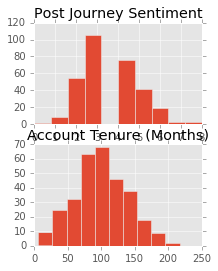

In [65]:
# Buttons: Reset, Select

button = widgets.Button(description="Update")
button.button_style = 'info'
button.margin = 5
button.height = 3

display.display(button)



def on_button_clicked(b):
    global global_selected_cust_df
    # print(d3sankeyExample.selected_json)
    if len(d3sankeyExample.selected_json) < 5 :
        print('please select at least one node.')
        return
    ss_json = json.loads(d3sankeyExample.selected_json)
    new_ss = {k: v for k, v in ss_json.items() if v == "y"}
    selected_journey=new_ss.keys()
    selected_journey_df=cust_journey_df[cust_journey_df.apply(lambda x: jouney_covered_check(selected_journey,x['journey']) , axis=1)]
    collecteddf = {'cust_id':  collect_customer_from_journey(selected_journey_df)}
    df_new = pd.DataFrame(collecteddf, columns = ['cust_id' ])
    global_selected_cust_df = df_new
    df_new = df_new.apply(pd.to_numeric, errors='ignore').sort_values(by='cust_id')
    collected_df = pd.merge(df_new, cust_df, how='inner', left_on='cust_id', right_on='cust_id.1')
    
    
    display.clear_output(wait=True)
    fig, axs = plt.subplots(2,1,figsize=(3,4))
    collected_df['sentiment'].hist(ax=axs[0])
    collected_df['Account Length'].hist(ax=axs[1])

    axs[0].set_title('Post Journey Sentiment')
    axs[1].set_title('Account Tenure (Months)')



button.on_click(on_button_clicked)

In [86]:
grade_top_row = widgets.HBox()

hid_txt = widgets.HTML("Segment Name:")
hid_txt.font = 'helvetica'
hid_txt.font_size = 30
hid_txt.margin = 5
algo_id_field = widgets.Text()
algo_id_field.height = 35
algo_id_field.value='Segment_1'

grade_txt = widgets.HTML("Segment Type:")
grade_select = widgets.Dropdown(options=["Marketing", "Promotion", "Retension"])



grade_btn = widgets.Button(description="Create")
grade_btn.margin = 5
grade_btn.button_style = 'info'


grade_top_row.children = (hid_txt, algo_id_field, grade_txt, grade_select, grade_btn)
grade_top_row.align = 'center'

comment_field = widgets.Textarea(value='')
comment_field.margin = 5
comment_field.width = 378
comment_field.cols = 55

grade_form = widgets.VBox()
grade_form.children = (grade_top_row, comment_field )


def on_create_button_clicked(b):
    # print(d3sankeyExample.selected_json)
    if len(d3sankeyExample.selected_json) < 5 :
        print('please select at least one node.')
        return
    new_seg = {'Seg_name': algo_id_field.value,
               'Seg_type': grade_select.value,
               'cust_ids': ','.join(global_selected_cust_df['cust_id'].tolist())
              }
    display.clear_output(wait=True)
    # print(json.dumps(new_seg))
    # print('<script> alert(\'' + json.dumps(new_seg) + '\'); </script>')
    # HTML('<script> alert(\'' + json.dumps(new_seg) + '\'); </script>')
    comment_field.value = json.dumps(new_seg)
    



grade_btn.on_click(on_create_button_clicked)


display.display(grade_top_row)

In [87]:
display.display(comment_field)